# 3_eda.ipynb
### Team: *Team Yunus*
### Made By: *Yunus Eren Ertas*

This notebook performs a detailed exploratory analysis of the cleaned UK
electricity demand dataset produced in `2_clean.ipynb`.

The goals of this EDA are:
- Understand the distribution of electricity demand
- Visualize important time-based patterns (daily, weekly, seasonal)
- Identify outliers and anomalies
- Detect long-term trends
- Prepare insights that guide model selection in later notebooks

All plots and explanations here will also be used in the final presentation.


### Load Clean Hourly Electricity Data

We load the file generated in Part 2 (`uk_electricity_hourly.parquet`).
This dataset has:
- continuous hourly timestamps
- no missing values
- realistic demand measurements
- cleaned outliers removed


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")

df = pd.read_parquet("../data/clean/uk_electricity_hourly.parquet")

df.head()


,demand_mw
2001-01-01 00:00:00,34715.0
2001-01-01 01:00:00,35354.5
2001-01-01 02:00:00,34112.0
2001-01-01 03:00:00,32361.0
2001-01-01 04:00:00,29971.5


### Basic Summary

We inspect the dataset to understand:
- number of rows
- date range
- basic statistics
- structure of the time-series index


In [24]:
df.info(), df.describe()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 217704 entries, 2001-01-01 00:00:00 to 2025-11-01 23:00:00
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   demand_mw  217704 non-null  float64
dtypes: float64(1)
memory usage: 3.3 MB


(None,
            demand_mw
 count  217704.000000
 mean    30258.740200
 std      7660.220938
 min     12158.000000
 25%     24059.500000
 50%     29869.500000
 75%     35982.000000
 max     54073.000000)

### Check the time coverage

We confirm the dataset covers all years from 2001 to 2025.


In [25]:
df.index.min(), df.index.max()


(Timestamp('2001-01-01 00:00:00'), Timestamp('2025-11-01 23:00:00'))

### Full Time Series Plot (2001–2025)

This gives an overview of:
- overall consumption levels
- seasonal structure (winter peaks, summer lows)
- multi-year trends (e.g. post-2008 efficiency improvements)
- anomalies such as COVID lockdown


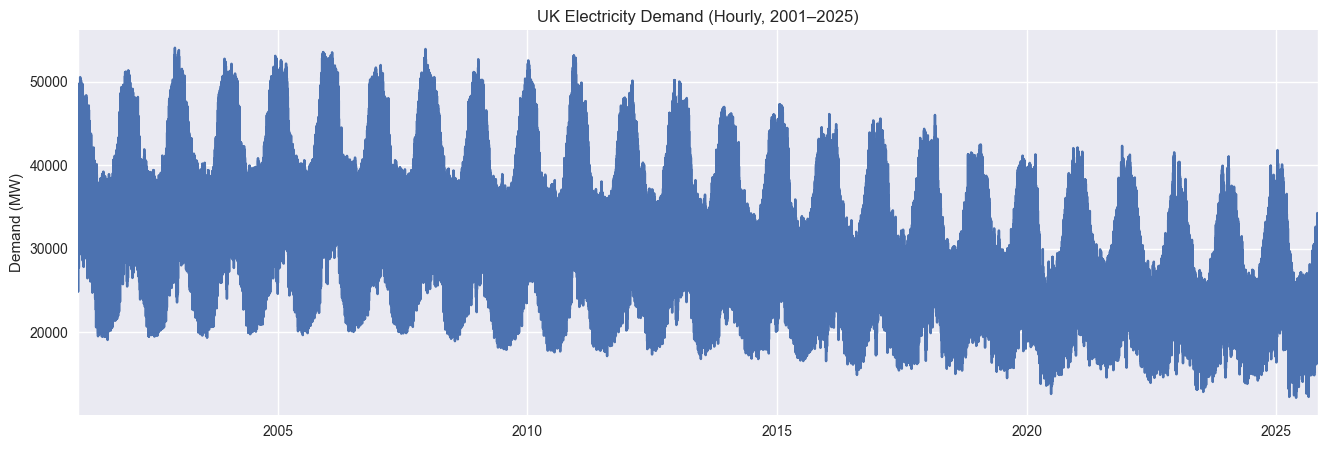

In [26]:
plt.figure(figsize=(16,5))
df["demand_mw"].plot()
plt.title("UK Electricity Demand (Hourly, 2001–2025)")
plt.ylabel("Demand (MW)")
plt.grid(True)
plt.show()


### Yearly Average Demand

We compute and visualize the mean demand for each year.
This reveals long-term changes (e.g., energy efficiency improvements).


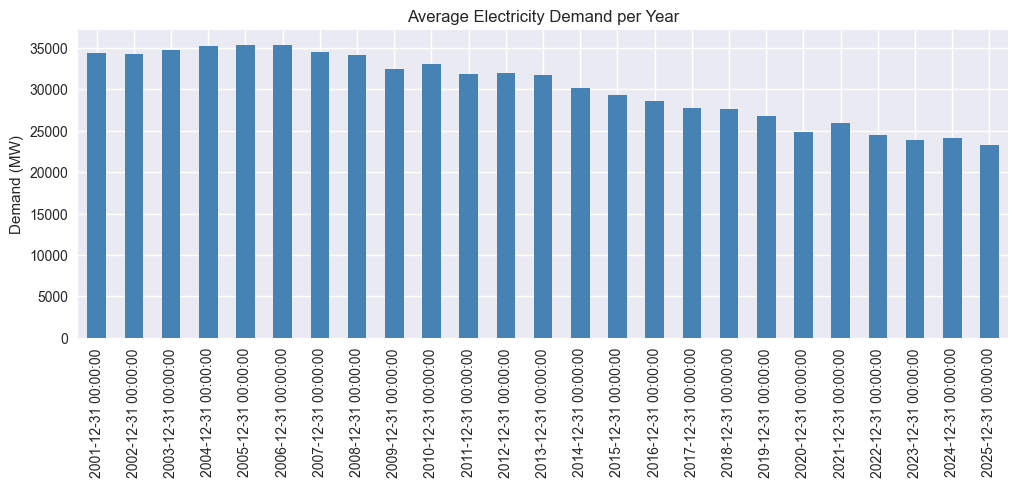

In [27]:
yearly = df["demand_mw"].resample("Y").mean()

plt.figure(figsize=(12,4))
yearly.plot(kind="bar", color="steelblue")
plt.title("Average Electricity Demand per Year")
plt.ylabel("Demand (MW)")
plt.show()


### Monthly Seasonality

We compute the average demand for each calendar month to visualize
seasonal usage patterns (cold winters, warm summers).


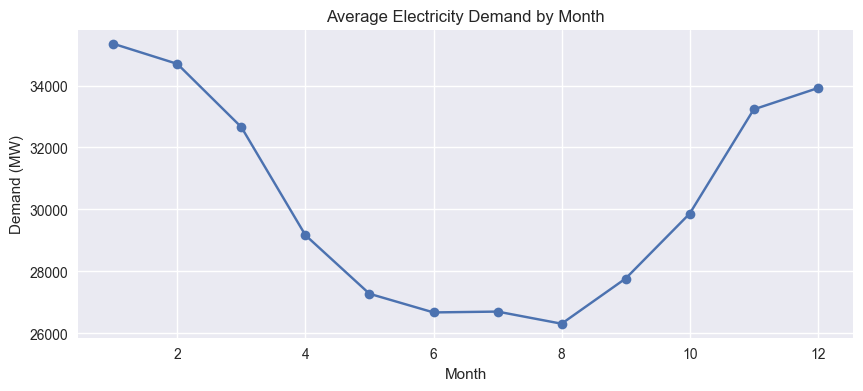

In [28]:
df["month"] = df.index.month
monthly = df.groupby("month")["demand_mw"].mean()

plt.figure(figsize=(10,4))
monthly.plot(marker="o")
plt.title("Average Electricity Demand by Month")
plt.xlabel("Month")
plt.ylabel("Demand (MW)")
plt.grid(True)
plt.show()


### Weekly Pattern (Monday–Sunday)

We examine differences between weekdays and weekends.


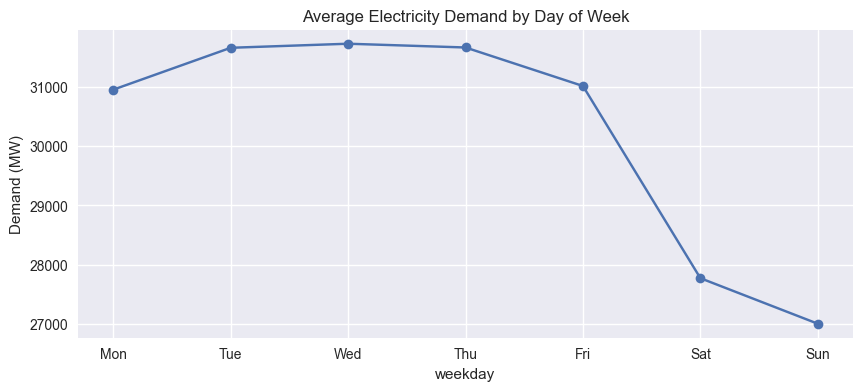

In [29]:
df["weekday"] = df.index.dayofweek  # 0=Mon, 6=Sun
weekly = df.groupby("weekday")["demand_mw"].mean()

plt.figure(figsize=(10,4))
weekly.plot(marker="o")
plt.xticks(range(7), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
plt.title("Average Electricity Demand by Day of Week")
plt.ylabel("Demand (MW)")
plt.grid(True)
plt.show()


### Hour-of-Day Pattern (24-hour cycle)

We compute the mean demand for each hour of the day.
This shows the daily consumption curve (morning ramp-up, evening peak).


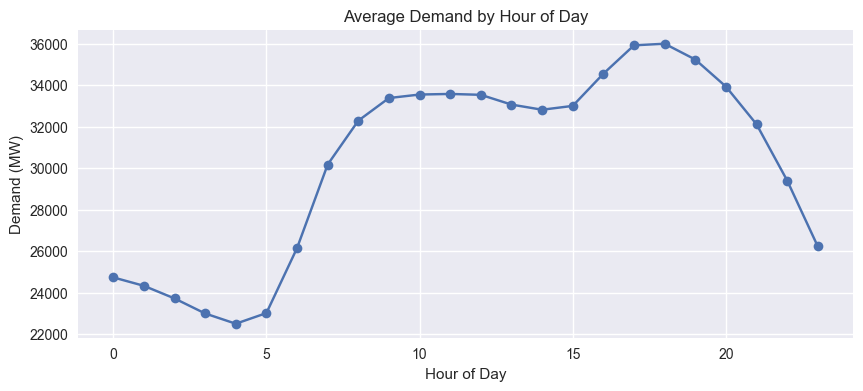

In [30]:
df["hour"] = df.index.hour
hourly_pattern = df.groupby("hour")["demand_mw"].mean()

plt.figure(figsize=(10,4))
hourly_pattern.plot(marker="o")
plt.title("Average Demand by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Demand (MW)")
plt.grid(True)
plt.show()


### Heatmap: Hour of Day × Weekday

This heatmap shows combined daily and weekly seasonality.  
It reveals:
- work-week patterns  
- weekend drops  
- night-time baseload  


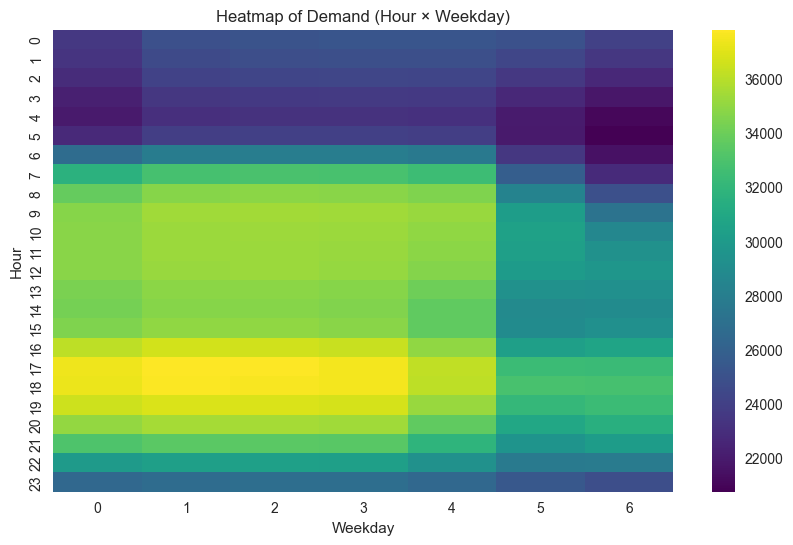

In [31]:
pivot = df.pivot_table(values="demand_mw", index="hour", columns="weekday", aggfunc="mean")

plt.figure(figsize=(10,6))
sns.heatmap(pivot, cmap="viridis")
plt.title("Heatmap of Demand (Hour × Weekday)")
plt.xlabel("Weekday")
plt.ylabel("Hour")
plt.show()


### Rolling Trends (7-day and 30-day averages)

Smoothing the time series allows us to observe:
- long-term structural trends
- seasonal cycles
- system changes over time


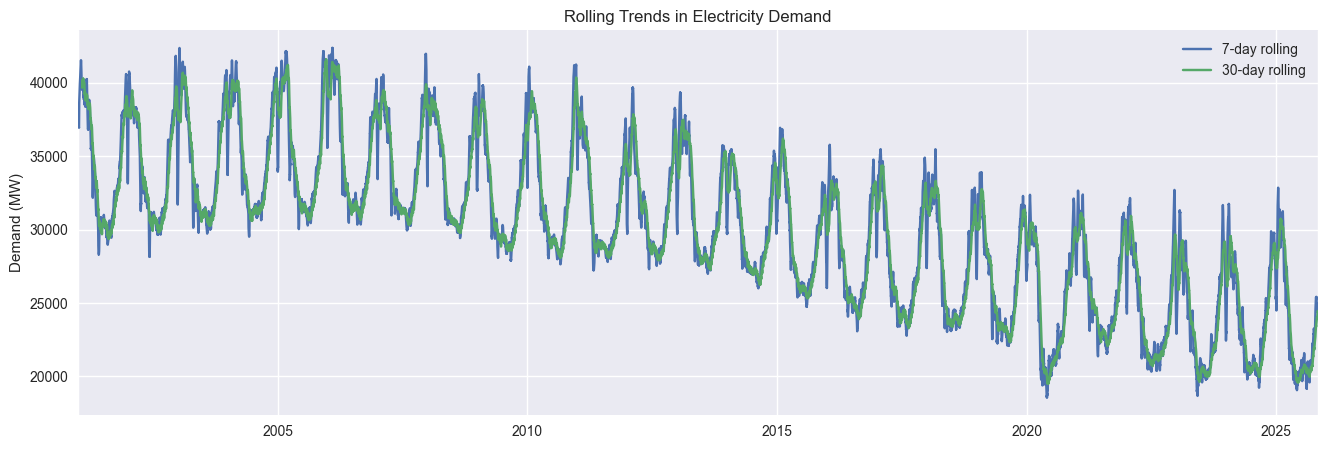

In [32]:
plt.figure(figsize=(16,5))
df["demand_mw"].rolling(24*7).mean().plot(label="7-day rolling")
df["demand_mw"].rolling(24*30).mean().plot(label="30-day rolling")
plt.title("Rolling Trends in Electricity Demand")
plt.ylabel("Demand (MW)")
plt.legend()
plt.grid(True)
plt.show()


### Outlier Analysis

We identify and visualize the highest and lowest demand events.
These often correspond to:
- extreme weather
- blackout events
- holidays
- COVID lockdowns


In [33]:
top = df.sort_values("demand_mw", ascending=False).head(10)
bottom = df.sort_values("demand_mw").head(10)

top, bottom


(                     demand_mw  month  weekday  hour
 2002-12-10 17:00:00    54073.0     12        1    17
 2007-12-17 17:00:00    53929.0     12        0    17
 2003-01-08 17:00:00    53805.0      1        2    17
 2005-11-28 17:00:00    53558.0     11        0    17
 2005-11-29 17:00:00    53557.5     11        1    17
 2003-01-07 17:00:00    53538.5      1        1    17
 2006-02-02 17:00:00    53527.0      2        3    17
 2005-11-30 17:00:00    53425.5     11        2    17
 2007-12-17 16:00:00    53391.5     12        0    16
 2005-12-07 17:00:00    53344.0     12        2    17,
                      demand_mw  month  weekday  hour
 2025-05-25 14:00:00    12158.0      5        6    14
 2025-04-05 14:00:00    12261.0      4        5    14
 2025-08-25 14:00:00    12261.5      8        0    14
 2025-08-25 13:00:00    12434.5      8        0    13
 2025-05-10 14:00:00    12448.5      5        5    14
 2020-06-28 05:00:00    12617.0      6        6     5
 2025-08-09 14:00:00    126

### Autocorrelation (ACF)

Autocorrelation reveals repeating patterns such as:
- daily seasonality (24-hour lag)
- weekly seasonality (168-hour lag)


<Figure size 1200x400 with 0 Axes>

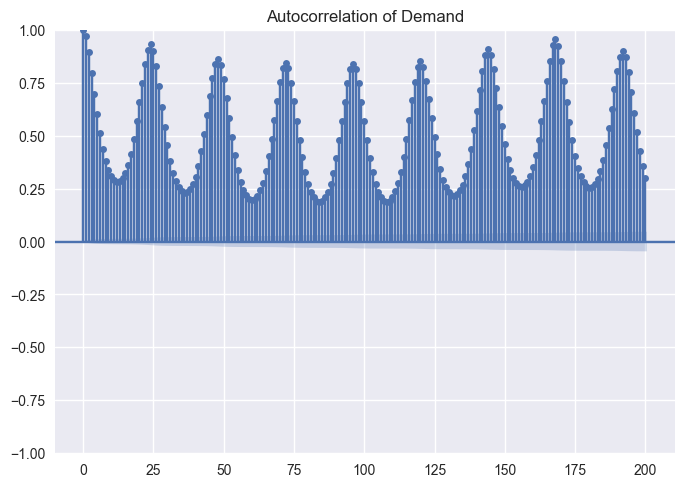

In [34]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(12,4))
plot_acf(df["demand_mw"], lags=200)
plt.title("Autocorrelation of Demand")
plt.show()


# ✔ EDA Complete

We have explored:
- overall demand trends
- seasonal patterns (daily, weekly, yearly)
- long-term changes
- anomalies and extreme events
- autocorrelation structure

This EDA provides the insights needed to choose and justify models in Part 4.
Proceed to the modeling notebook: `04-model.ipynb`.
